In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, fbeta_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier

In [2]:
seed = 42

In [3]:
# Load cleaned data into DataFrame
stroke_df = pd.read_csv('stroke_data_cleaned.csv')

# 1. Preprocessing
Since the XGBoost classifier requires numerical inputs, I will first preprocess the data by seperating out and one-hot encoding the categorical features.  One-hot encoding is preferable over mapping to integer values since integer values have an inherent relationship due to their ordering.

In [4]:
# Seperate into data frames for the label, categorical features, and continuous features
label_df = stroke_df['stroke']
cat_df = stroke_df[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]
non_cat_df = stroke_df[['age', 'avg_glucose_level', 'bmi']]

In [5]:
# Encode the categorical features
encoder = OneHotEncoder(sparse='false', drop='if_binary')
encoded_data = encoder.fit_transform(cat_df).toarray()

In [6]:
# Combine Categorical and continuous features
features = np.hstack((encoded_data, non_cat_df.to_numpy()))
features.shape

(4909, 19)

In [7]:
# Convert label dataframe to numpy column
labels = label_df.to_numpy()
labels.shape

(4909,)

# 2. Hyperparameter Tuning with Grid Search

## Setting up Cross-Validation
For hyperparameter tuning I will be using K-folds Cross-Validation with 5 splits and 3 repeats.  This means the model will be trained 15 times for each unique set of parameters.

In [8]:
# Setup Cross-validation
cross_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)

# Setup XGBoost model
model = XGBClassifier(verbosity=0, use_label_encoder=False)

## Define hyper-parameter space
The XGBoost Classifier has many hyperparameters.  I have selected a subset of the 5 main hyperparameters for the grid search.  This means that there will be $4^3 * 2^2$ unique sets of parameters, thus the model will be trained a total of $(4^3 * 2^2) * 15 = 3,840$ times

In [9]:
# Define parameter space for Grid Search
param_space = {'n_estimators': [50, 100, 200, 400], 'max_depth': [4, 8, 12, 16], \
               'learning_rate': [0.001, 0.01, 0.1, 1.0], 'subsample': [0.5, 1.0], 'colsample_bytree': [0.5, 1.0]}

## Perform Grid Search
The Grid Search will train models for each of the unique sets of hyper-parameters in the defined parameter space and evaluate them according to the cross validation method provided.  Additionally, the grid search will use the scoring method provided to compare the models.  In this case, I have chosen to score the models with the F2 value.
### F2 scoring
The F2 score provides more weight to recall, thus discouraging false negatives.  For stroke prediction, reducing the number of false negatives is very important as any false negative could put someone's life at risk.

In [10]:
# Define the F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

In [11]:
# Run the Grid Search using F2 scoring to compare models
grid_search = GridSearchCV(estimator=model, param_grid=param_space, scoring=f2_scorer, cv=cross_val, verbose=2)

grid_search.fit(features, labels)

Fitting 15 folds for each of 256 candidates, totalling 3840 fits
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] EN

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=4,

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estim

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=8,

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=50,

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estima

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=8, n_estima

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=12,

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estim

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=16,

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=100,

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=400,

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=8, n_estimators=200,

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=50,

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=12, n_estima

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimat

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=16, n_estima

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=50, subsampl

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=8, n_estimators=200,

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimat

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   0.9s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=12, n_estima

[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=1.0, max_depth=16, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estim

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=4,

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_es

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8, n_estimators=400, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=8,

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=12, n_estimators=400, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_dept

[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.001, max_

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=50,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estimators=400, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=12,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estim

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16, n_estimators=400, subsample=0.5; total time=   2.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=16,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=100,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=4, n_estimators=400,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.5; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=50,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=100, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=0.5; total time=   1.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estimators=400, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=16, n_estima

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=50, subsampl

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=8, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estima

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=0.5; total time=   1.2s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estimators=400, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=12, n_estima

[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estimators=200, subsample=0.5; total time=   0.7s
[CV] END colsample_bytree=1.0, learning_rate=1.0, max_depth=16, n_estima

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=Non...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     val

In [21]:
grid_search.best_score_

0.12770813836716327

# 3. Train model with best parameters

In [12]:
# Randomly split the data into train and test set
test_size = 0.2
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, \
                                                                    test_size=test_size, random_state=seed, shuffle=True)

In [15]:
n_estimators = grid_search.best_params_['n_estimators']
max_depth = grid_search.best_params_['max_depth']
learning_rate = grid_search.best_params_['learning_rate']
subsample = grid_search.best_params_['subsample']
colsample_bytree = grid_search.best_params_['colsample_bytree']

In [28]:
# Train model with best parameters found in Grid Search
final_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, \
                            subsample=subsample, colsample_bytree=colsample_bytree, verbosity=0, use_label_encoder=False)
final_model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

## Evaluate
Evaluating the model will require looking at more than just the accuracy.  Since our dataset is imbalanced and has far fewer positive example, accuracy can be misleading.  A high accuracy could be achieved by a model that simply selects the negative every time.  Instead we want to focus in on the model's performance on the positive class by looking at the Precision, Recall, F1 score, and F2 score.

In [29]:
# Use model to make predictions on test set
test_predictions = final_model.predict(test_data)

# Compute Accuracy, Precision and Recall
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(test_labels, test_predictions)
print("Precision: %.2f" % (precision))
recall = recall_score(test_labels, test_predictions)
print("Recall: %.2f" % (recall))
f1 = f1_score(test_labels, test_predictions)
print("f1 score: %.2f" % (f1))
f2 = fbeta_score(test_labels, test_predictions, beta=2)
print("f2 score: %.2f" % (f2))

Accuracy: 91.65%
Precision: 0.06
Recall: 0.04
f1 score: 0.05
f2 score: 0.04


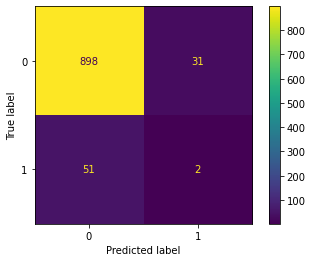

In [30]:
# Compute and Display the confusion matrix
conf_mat = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()